# Vehicle Detection Project

#### Overview

Uses techniques from lesson to do vehicle detection. 

The project data set is used for training with one additional augmentation (flipping the image).

Features extracted are binned color, histogram of colors and Hog features on all channels.

HLS Colorspace is being submitted (I encountered NaN's when YUV or LUV spaces were attempted). All other colorspaces were tried, but HLS seems to give better tradeoffs.

Linear SVC is used for training with default parameters. (Note: Rbf kernel was also experimented and not much improvement was observed w.r.t vehicle identification. In light of extended training times with Rbf kerenels, Linear kernel is being submitted)


find_cars() method is used from the lesson to detect cars. After experimenting with various parameters, settled on the parameters being submitted.

In order to reduce false +ves, following method is used.

    -- Basic heat method from the lesson is used
    -- Accummulate heat for last N frames
    -- Threshhold the heat to some fraction to account for the number of frames that the car is actually detected.
    -- (Discussion on various tradeoffs is presented later)
    

In [7]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: last import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split  

%matplotlib inline

#### Input Data and Analysis

In [8]:
# Read in cars and notcars
images = glob.glob('*vehicles/*/*')
cars = []
notcars = []
for image in images:
    if 'non' in image:
        notcars.append(image)
    else:
        cars.append(image)
cars_size = len(cars)
notcars_size = len(notcars)
## Uncomment if need to reduce the sample size
#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]
print("Num of Cars:", cars_size, "Num of Not Cars:", notcars_size)


Num of Cars: 8792 Num of Not Cars: 8968


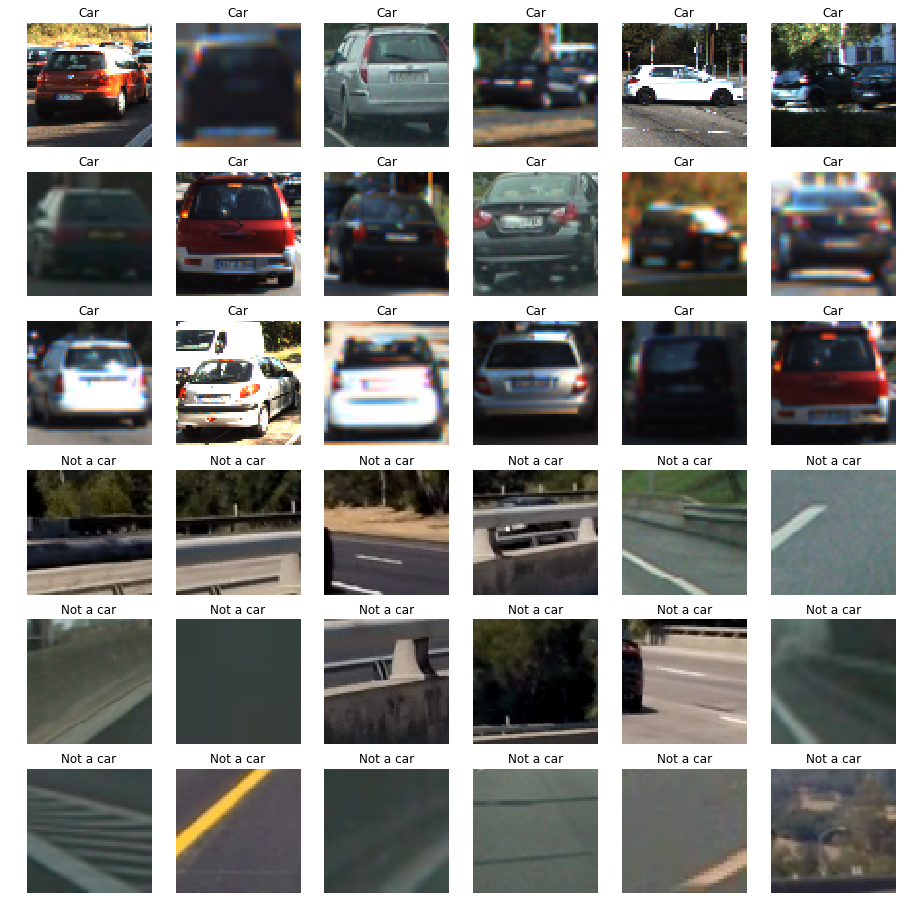

In [9]:
# Visualize cars and non cars

fig, axs = plt.subplots(6,6, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in np.arange(18):
    img = cv2.imread(cars[np.random.randint(0,cars_size)])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Car', fontsize=12)
    axs[i].imshow(img)
for i in np.arange(18,36):
    img = cv2.imread(notcars[np.random.randint(0,notcars_size)])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Not a car', fontsize=12)
    axs[i].imshow(img)


#### Feature Extraction

Utility functions to extract features. Largely from the lessons.

Single image features extraction is used to help overall features extraction.

Images are augmented with basic "flip". I was hoping it would reduce false +ves, but did not see significant improvement even though training data set is doubled.

In [10]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
# Color conversion is done (RGB was not reliable) always before this function is called (pixel values are always in 0-255 range)
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return feature vector
    return hist_features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to extract features from a list of images
# Have this function call single_img_features
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        img_features = single_img_features(image, color_space, spatial_size,
                                            hist_bins, orient, pix_per_cell, cell_per_block, hog_channel,
                                            spatial_feat, hist_feat, hog_feat)
        features.append(img_features)
        
        # Augment the images by flipping them.
        flipped_img = cv2.flip(image, 1)
        flipped_img_features = single_img_features(flipped_img, color_space, spatial_size,
                                            hist_bins, orient, pix_per_cell, cell_per_block, hog_channel,
                                            spatial_feat, hist_feat, hog_feat)
        features.append(flipped_img_features)
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [11]:
# Global variables for all parameters.

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

#### Hog Features 

As can be seen from the following visualizations, sometimes, hog features for non-car images do not look much different. This is probably one of the factors in detecting false +ves.

/Users/sdcar/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


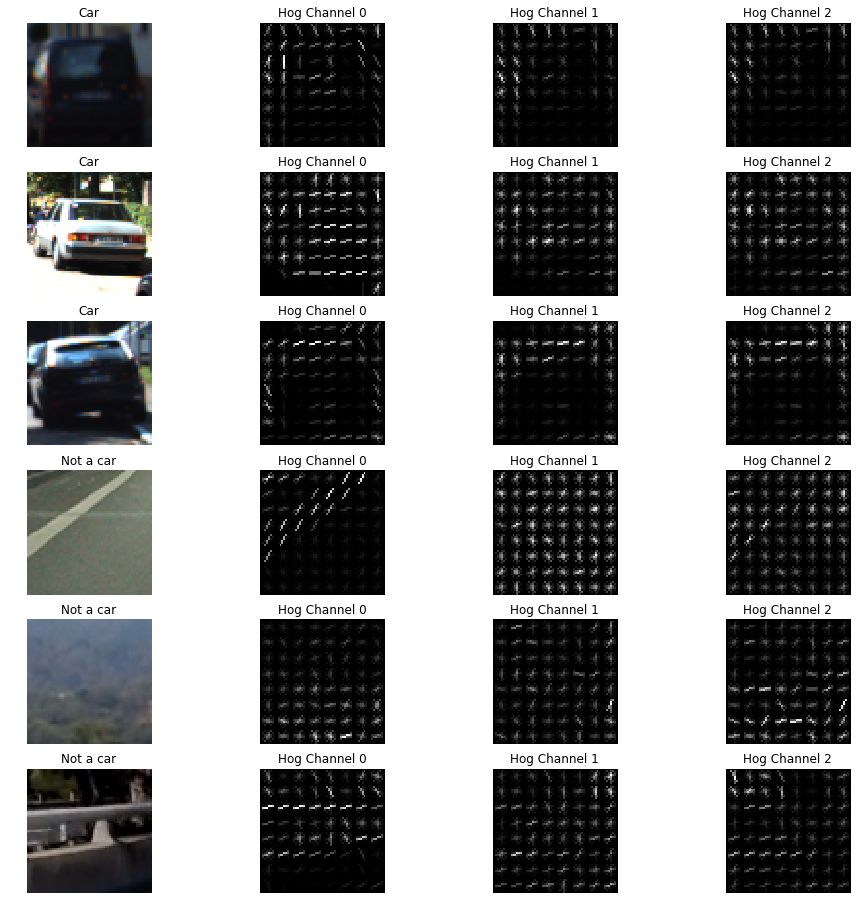

In [12]:
# Visualize Hog features

fig, axs = plt.subplots(6,4, figsize=(16, 16))
fig.subplots_adjust(hspace = .2)

for i in np.arange(0,3):
    img = mpimg.imread(cars[np.random.randint(0,cars_size)])
    hogimg = cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
    _, hog_img0 = get_hog_features(hogimg[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
    _, hog_img1 = get_hog_features(hogimg[:,:,1], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
    _, hog_img2 = get_hog_features(hogimg[:,:,2], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
    axs[i][0].axis('off')
    axs[i][0].set_title('Car', fontsize=12)
    axs[i][0].imshow(img)
    axs[i][1].axis('off')
    axs[i][1].set_title('Hog Channel 0', fontsize=12)
    axs[i][1].imshow(hog_img0, cmap='gray')
    axs[i][2].axis('off')
    axs[i][2].set_title('Hog Channel 1', fontsize=12)
    axs[i][2].imshow(hog_img1, cmap='gray')
    axs[i][3].axis('off')
    axs[i][3].set_title('Hog Channel 2', fontsize=12)
    axs[i][3].imshow(hog_img2, cmap='gray')

for i in np.arange(3,6):
    img = mpimg.imread(notcars[np.random.randint(0,notcars_size)])
    hogimg = cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
    _, hog_img0 = get_hog_features(hogimg[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
    _, hog_img1 = get_hog_features(hogimg[:,:,1], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
    _, hog_img2 = get_hog_features(hogimg[:,:,2], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
    axs[i][0].axis('off')
    axs[i][0].set_title('Not a car', fontsize=12)
    axs[i][0].imshow(img)
    axs[i][1].axis('off')
    axs[i][1].set_title('Hog Channel 0', fontsize=12)
    axs[i][1].imshow(hog_img0, cmap='gray')
    axs[i][2].axis('off')
    axs[i][2].set_title('Hog Channel 1', fontsize=12)
    axs[i][2].imshow(hog_img1, cmap='gray')
    axs[i][3].axis('off')
    axs[i][3].set_title('Hog Channel 2', fontsize=12)
    axs[i][3].imshow(hog_img2, cmap='gray')


#### Trainig

Training is done with Linear SVM. I experimented with GridSearch with various C (range 1-10) paremeters and rbf kernel. There was not significant difference in the number(qualitatively) of false +ves and final Video performance. Hence finalized on Linear SVM with default parameters.

Experimented with various Color spaces. RGB was least performing while YCrCb and HLS were on the "better side" w.r.t false +ves. LUV and YUV were giving NaN in Training Data(extracted features), and could not experiment with them

Based on this paper(http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf) on HOG features, although I experimented with various (orientations, pix_per_cell, cell_per_block), I settled on (9,8,2) as final params as each combination has either more false positives(seemigly, wish there is a way to detect false +ves programmatically and score these parameters) or worse performance.

In [13]:
## Training using Linear SVC

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
t1=time.time()
car_features = extract_features(cars, color_space=colorspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=colorspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
t2=time.time()
print(round(t2-t1, 2), 'Seconds to extract features...')

# # Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# # Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]), ' Samples:', len(X_train) )

t3=time.time()
print(round(t3-t2, 2), 'Seconds to scale...')
# Simple Linear SVC
svc = LinearSVC()
#svc = svm.SVC(kernel='rbf', C=10)
svc.fit(X_train, y_train)
t4 = time.time()
print(round(t4-t3, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


Using: 9 orientations 8 pixels per cell and 2 cells per block


/Users/sdcar/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


224.92 Seconds to extract features...
Feature vector length: 8556  Samples: 28416
45.31 Seconds to scale...
70.22 Seconds to train SVC...
Test Accuracy of SVC =  0.9876


#### Finding Cars in an Image

Adapted from the lesson. Cells_per_step is changed 1 to ge a coverage of the sliding window. While experimenting with other values, 1 seems a better choice at the cost of higher processing.

While finding cars, the corresponding boxes are also returned.

/Users/sdcar/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


25


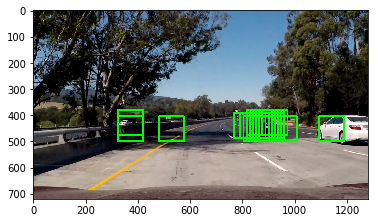

10


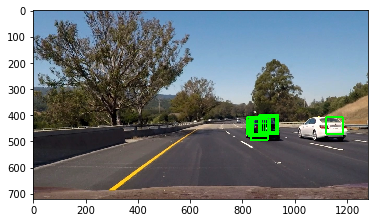

In [14]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, cspace, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    img_tosearch = img_tosearch.astype(np.float32)/255
    
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
#    print("image shape", ctrans_tosearch.shape)    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps 
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block  + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            if (hog_feat == True) :
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            if (spatial_feat == True) :
                spatial_features = bin_spatial(subimg, size=spatial_size)
            if (hist_feat == True) :
                hist_features = color_hist(subimg, nbins=hist_bins)

            # Stack & Scale features and make a prediction
            test_features = []

            if (spatial_feat == True) :
                test_features = np.hstack((test_features, spatial_features))
            if (hist_feat == True) :
                test_features = np.hstack((test_features, hist_features))
            if (hog_feat == True) :
                test_features = np.hstack((test_features, hog_features))    
            
            # test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
            test_features = X_scaler.transform(test_features.reshape(1, -1)) 
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,255,0),6) 
                
    return draw_img, boxes

ystart = 380
ystop = 500
scale = 1.5
image = mpimg.imread('test_images/test5.jpg')
draw_img, boxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, colorspace, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

print (len(boxes))
plt.imshow(draw_img)
plt.show()

ystart = 400
ystop = 600
scale = 1.0
image = mpimg.imread('test_images/test6.jpg')
draw_img, boxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, colorspace, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

print (len(boxes))
plt.imshow(draw_img)
plt.show()

The above shows that when increasing scale, cars farther on the horizon may not be detected.

#### Heat Map

Using the heat map approach from the lesson. 

In [15]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def sub_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Subtract 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] -= 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    if (labels == []) :
        return img
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def detect_cars_in_singleimage(file_p, thresh=2, scale=1.5, output=0):

    ystart = 380
    ystop = 656

    image = mpimg.imread(file_p)
    
    _, boxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, colorspace, 
                                orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,boxes)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,thresh)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure(figsize=(10,8))
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions:'+ file_p)
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    plt.show()
    
    if (output) :
        outfile = file_p.split('.')[0]+'out.jpg'
        fig.savefig(outfile)


#### Visualize Test Images and Heatmap

Followig are the test images for the project. There are some false +ves and some false -ves. Hopefully, these will go away when cars are detceted across multiple frames. Adjusting the scale would affect detection of cars that are nearby vs far away. While processing Video frames, each frame is scanned multiple times at different scale levels to detect all possible cars, also increasing the possibility of false +ves at each scale.

/Users/sdcar/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


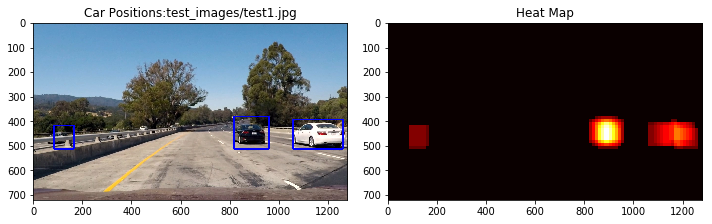

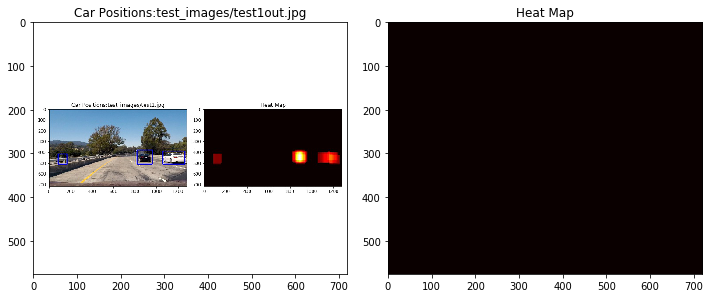

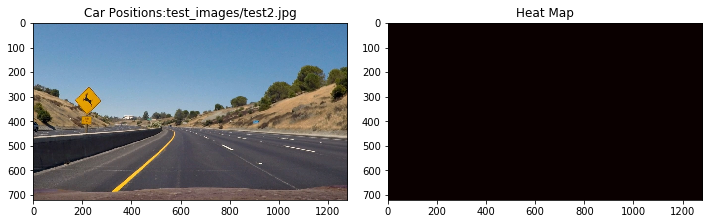

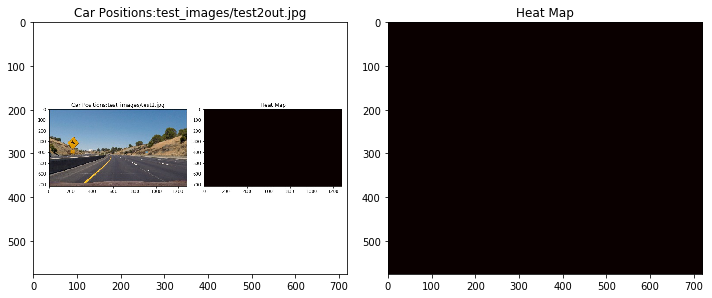

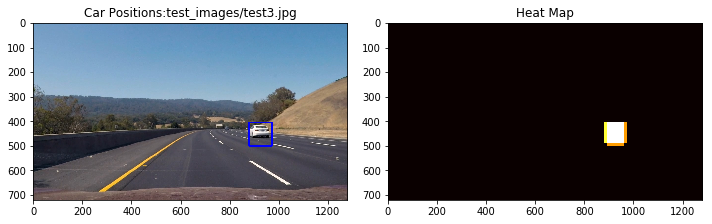

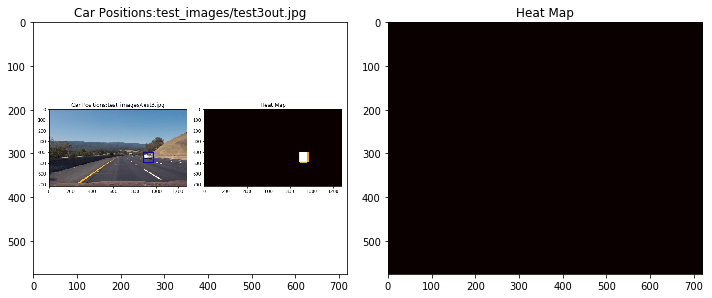

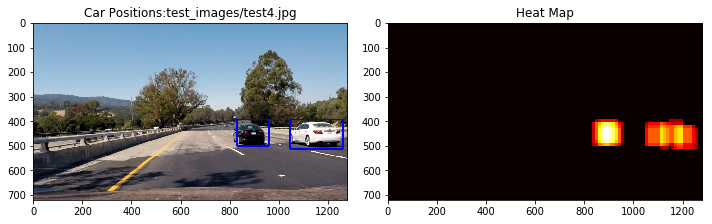

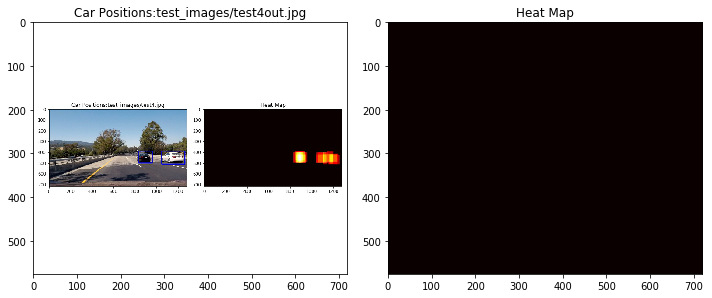

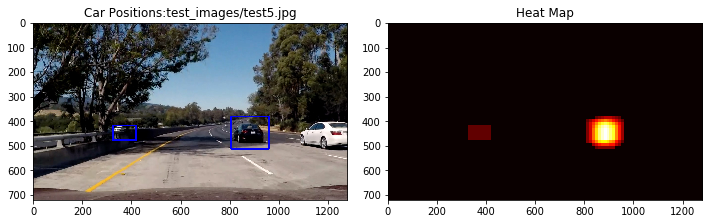

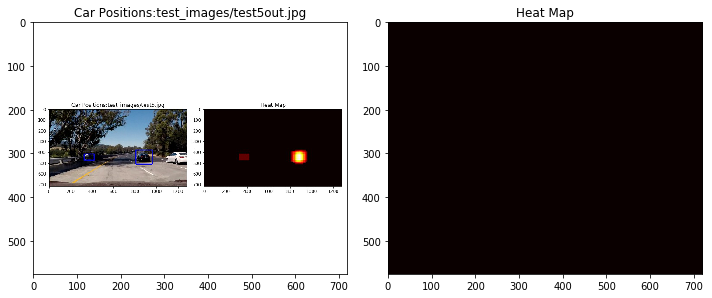

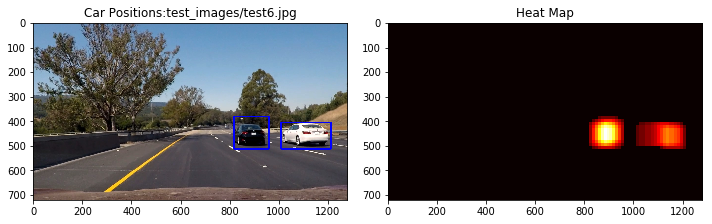

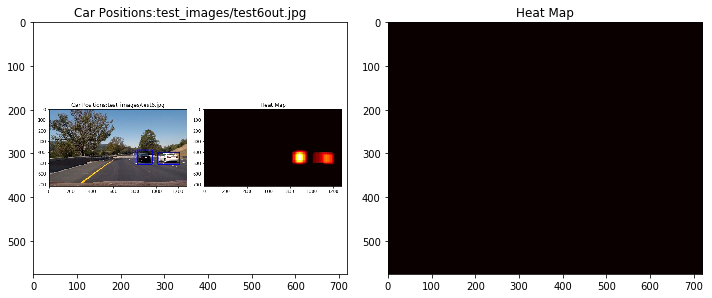

In [16]:

for file_p in glob.glob('test_images/test*.jpg'):
    detect_cars_in_singleimage(file_p,2, 1.5, 1)

#### False +ve Removal

False +ves are removed using heatmap approach, by looking at multiple frames. Looking at the heatmap from the last N frames, and applying a threshhold on the intensity of heatmap, most false +ves are eliminated, but few still remain. 

Each frame is scanned for cars at different scales. Cars farther on the horizon are smaller and typically a scale of 1.5 will be good to detect, but as the cars are nearer, scale has to increae and the number of passes on the image impacts performance. 

Although an attempt has been made to reduce the scan area depending on the scale, this is one aspect where I need to improve in future.

In [23]:

CACHED_FRAMES=5
def frame_proc(image, video=True) :
    global labels, cached_boxes, heat, n_frames

    # Initialize per frame boxes and heat.
    boxes_per_frame = []
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Make multiple passes on the frame at different scales, try to restrict the area of search depending on the scale.

    # Cars father on the horizon at lower scale.
    
    ystart = 380
    ystop = 480
    scale = 0.8
    _, boxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, colorspace, orient, 
                                pix_per_cell, cell_per_block, spatial_size, hist_bins)
    boxes_per_frame.append(boxes)
    
    ystart = 380
    ystop = 550
    scale = 1.5
    _, boxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, colorspace, orient, 
                                pix_per_cell, cell_per_block, spatial_size, hist_bins)
    boxes_per_frame.append(boxes)

    # As they come nearer, increase the scale
    ystart = 400
    ystop = 600
    scale = 2.0
    _, boxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, colorspace, orient, 
                                pix_per_cell, cell_per_block, spatial_size, hist_bins)
    boxes_per_frame.append(boxes)
    
    
    ystart = 450
    ystop = 680
    scale = 3.0
    _, boxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, colorspace, orient, 
                                pix_per_cell, cell_per_block, spatial_size, hist_bins)
    boxes_per_frame.append(boxes)
        
    boxes = [item for sublist in boxes_per_frame for item in sublist]
    # boxes now cotain all possible bounding boxes from one frame.
    
    # Append to the list of boxes being accumulated
    # Each item in cached_boxes contails all the bounding boxes from one frame
    cached_boxes.append(boxes); 
    n_frames = n_frames + 1

    if (len(cached_boxes) > CACHED_FRAMES) :   # First CACHED_FRAMEs are ignored.

        cached_boxes = cached_boxes[-CACHED_FRAMES:] # Keep only last CACHED_FRAMES seen.
        curr_boxes = [item for sublist in cached_boxes for item in sublist]
        # Add heat from all the accumulated boxes from the last CACHED_FRAMES
        heat = add_heat(heat, curr_boxes)
        # Find the max heat and take a fraction of that as the threshold
        # Increasing the threshhold will improve the false +ves
        # Lower thresholds introduces delay in detecting cars, as they are passing by 
        #     or forgetting a car that is farther in the horizon
        max_heat = np.max(heat)
        thresh = max(3, int(max_heat*0.2))
        heat = apply_threshold(heat, thresh)
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        
    return draw_labeled_bboxes(np.copy(image), labels)
    

In [18]:

# for file_p in glob.glob('vframes5/vframe*.jpg'):
#     detect_cars_in_singleimage(file_p,1, 1.5, 1)
    

In [ ]:
from moviepy.editor import VideoFileClip
n_frames = 0

cached_boxes = []
labels = []
def process_image(image):
#     image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return cv2.cvtColor(frame_proc(image), cv2.COLOR_BGR2RGB)
#clip1 = VideoFileClip("project_video.mp4")
output_v = 'project_video_proc.mp4'
#clip1 = VideoFileClip("project_video.mp4").subclip(38, 40)
clip1 = VideoFileClip("project_video.mp4")
#clip1.write_images_sequence("vframes5/vframe%03d.jpg")
clip = clip1.fl_image(frame_proc)
%time clip.write_videofile(output_v, audio=False) 

[MoviePy] >>>> Building video project_video_proc.mp4
[MoviePy] Writing video project_video_proc.mp4


  1%|          | 9/1261 [00:18<43:16,  2.07s/it]

In [22]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_v))

### Discussion and Improvements

It was a challenge to reduce the false +ves. Most of the false +ves are in the shadows, guard rails or lanes. 
It is possible these are under-represented in the training dataset. If 'predict' is more reliable, it is possible to eliminate false +ves at the prediction time itself, allowing to go more aggressive on thresholding on the heatmap. I.e we can use higher threshholds and not miss real cars. Otherwise, having higher thresholds may miss to detect cars that are properly detected.

More intelligent scale values are another area where detection can be enhanced and reduce false +ves. For example, depending on the area being looked at, scale factor can be automatically adjusted and limit scan to one pass.
